<h3>In this notebook I'll use already preprocessed
    one in the real_estate_sklearn
</h3>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

In [3]:
df = pd.read_csv('real_estate_processed.csv', index_col='No')

In [5]:
df.head(5)

,type,municipalitycode,prefecture,municipality,districtname,neareststation,timetoneareststation,tradeprice,frontageisgreaterflag,buildingyear,structure,use,cityplanning,coverageratio,floorarearatio,age
No,,,,,,,,,,,,,,,,
1,pre-owned_condominiums,13101,tokyo,chiyoda_ward,iidabashi,iidabashi,4,40000000,False,2013,rc,house,commercial_zone,80,500,8
2,pre-owned_condominiums,13101,tokyo,chiyoda_ward,iidabashi,iidabashi,4,130000000,False,2007,rc,house,commercial_zone,80,500,14
3,residential_land(land_and_building),13101,tokyo,chiyoda_ward,iidabashi,iidabashi,2,400000000,False,2018,s,"office,_shop",commercial_zone,80,500,3
4,residential_land(land_and_building),13101,tokyo,chiyoda_ward,iidabashi,iidabashi,1,180000000,False,1976,rc,"housing_complex,_office",commercial_zone,80,700,45
5,pre-owned_condominiums,13101,tokyo,chiyoda_ward,iidabashi,iidabashi,4,100000000,False,2007,rc,house,commercial_zone,80,500,14


In [6]:
df.isnull().sum()

type                     0
municipalitycode         0
prefecture               0
municipality             0
districtname             0
neareststation           0
timetoneareststation     0
tradeprice               0
frontageisgreaterflag    0
buildingyear             0
structure                0
use                      0
cityplanning             0
coverageratio            0
floorarearatio           0
age                      0
dtype: int64

# Small preparation

In [7]:
full_train, df_test = train_test_split(df, random_state=4, test_size=0.2)
df_train, df_valid = train_test_split(full_train, random_state=8, test_size=0.33)

In [8]:
y_train = np.log1p(df_train.tradeprice.values)
y_test = np.log1p(df_test.tradeprice.values)
y_valid = np.log1p(df_valid.tradeprice.values)

del df_train['tradeprice']
del df_test['tradeprice']
del df_valid['tradeprice']

In [9]:
df.dtypes

type                     object
municipalitycode          int64
prefecture               object
municipality             object
districtname             object
neareststation           object
timetoneareststation      int64
tradeprice                int64
frontageisgreaterflag      bool
buildingyear              int64
structure                object
use                      object
cityplanning             object
coverageratio             int64
floorarearatio            int64
age                       int64
dtype: object

In [10]:
numerical = ['timetoneareststation', 'buildingyear', 'coverageratio', 'floorarearatio']

categorical = ['type', 'municipality', 'districtname', 'neareststation',
               'structure', 'use', 'cityplanning', 'municipalitycode', 'age']

In [11]:
train_dict = df_train[numerical + categorical].to_dict(orient='records')
valid_dict = df_valid[numerical + categorical].to_dict(orient='records') 

In [12]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_valid = dv.transform(valid_dict)

# Decision Tree

In [22]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [23]:
y_pred_train = dtr.predict(X_train)
y_pred_valid = dtr.predict(X_valid)

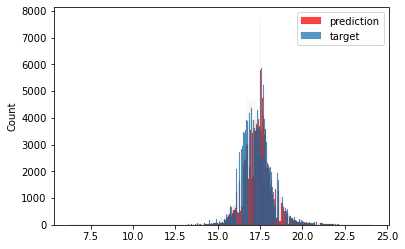

In [24]:
sns.histplot(y_pred_train, label='prediction', color='red')
sns.histplot(y_train, label='target')
plt.legend()
plt.show()

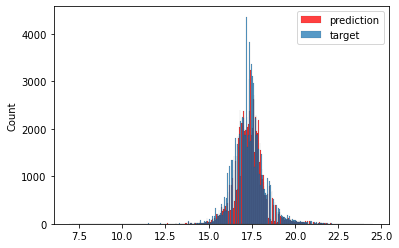

In [25]:
sns.histplot(y_pred_valid, label='prediction', color='red')
sns.histplot(y_valid, label='target')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

def metrics(y_test, y_pred, X_train):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    n = y_pred.shape[0]
    k = X_train.shape[1]
    
    adjusted = 1 - (1 - r2) * (n - 1) / (n - 1 - k)
    return rmse, r2, adjusted


In [31]:
rmse, r2, r2_adjusted = metrics(y_train, y_pred_train, X_train)
print(rmse, r2, r2_adjusted)

rmse, r2, r2_adjusted = metrics(y_valid, y_pred_valid, X_valid)
print(rmse, r2, r2_adjusted)

0.270010335633118 0.9144223675118258 0.9134778309546061
0.7213307961543047 0.38621547299854575 0.37230303931455955


# Parameter tuning

In [33]:
for d in [1, 5, 10, 20, 30, None]:
    dtr = DecisionTreeRegressor(max_depth=d, random_state=5)
    dtr.fit(X_train, y_train)
    y_pred = dtr.predict(X_valid)
    rmse, r2, r2_ad = metrics(y_valid, y_pred, X_valid)
    print(f"{d}, {round(rmse, 4)}, {round(r2, 4)}, {round(r2_ad, 4)}")

1, 0.861, 0.1255, 0.1057
5, 0.7107, 0.4042, 0.3907
10, 0.6592, 0.4874, 0.4758
20, 0.6538, 0.4958, 0.4843
30, 0.6713, 0.4683, 0.4563
None, 0.7199, 0.3886, 0.3748


In [34]:
# from previous we see that best depth is 20
for leaf in [1, 5, 10, 15, 20]:
    dtr = DecisionTreeRegressor(max_depth=20 , random_state=5, min_samples_leaf=leaf)
    dtr.fit(X_train, y_train)
    y_pred = dtr.predict(X_valid)
    rmse, r2, r2_ad = metrics(y_valid, y_pred, X_valid)
    print(f"{leaf}, {round(rmse, 4)}, {round(r2, 4)}, {round(r2_ad, 4)}")

None, 0.6538, 0.4958, 0.4843
None, 0.6347, 0.5247, 0.514
None, 0.6301, 0.5317, 0.5211
None, 0.6301, 0.5316, 0.521
None, 0.6292, 0.5331, 0.5225


In [35]:
# with `min_samples_leaf` best case when it's 20
# Last one is `max_features`
for f in [None, 1, 5, 10, 20, 50]:
    dtr = DecisionTreeRegressor(max_depth=20, min_samples_leaf=20,
                                max_features=f, random_state=5)
    dtr.fit(X_train, y_train)
    y_pred = dtr.predict(X_valid)
    rmse, r2, r2_ad = metrics(y_valid, y_pred, X_valid)
    print(f"{f}, {round(rmse, 4)}, {round(r2, 4)}, {round(r2_ad, 4)}")

None, 0.6292, 0.5331, 0.5225
1, 0.9192, 0.0032, -0.0194
5, 0.9145, 0.0134, -0.009
10, 0.9147, 0.013, -0.0094
20, 0.8865, 0.0729, 0.0518
50, 0.7711, 0.2987, 0.2828


# Final Decision Tree Regressor

In [12]:
y_full_train = np.log1p(full_train.tradeprice.values)

del full_train['tradeprice']

In [13]:
dict_full_train = full_train[numerical + categorical].to_dict(orient='records')
dict_test = df_test[numerical + categorical].to_dict(orient='records')

In [14]:
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)
X_test = dv.transform(dict_test)

In [15]:
dtr = DecisionTreeRegressor(max_depth=20, min_samples_leaf=20,
                            max_features=None, random_state=5)

dtr.fit(X_full_train, y_full_train)
final_prediction = dtr.predict(X_test)

In [18]:
rmse, r2, r2_ad = metrics(y_test, final_prediction, X_test)

print(f"{round(rmse, 4)}, {round(r2, 4)}, {round(r2_ad, 4)}")

0.6198, 0.5424, 0.5284


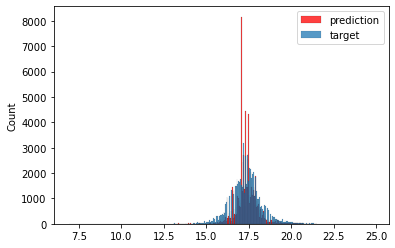

In [115]:
sns.histplot(final_prediction, label='prediction', color='red')
sns.histplot(y_test, label='target')
plt.legend()
plt.show()

# Check

In [111]:
import random

def get_random(start=2500, end=320000):
    return random.randint(start, end)

In [112]:
def calculate_difference(price, prediction):
    result = (prediction / price) * 100
    return round(result, 2)

In [113]:
def check_fluctuation(dv, dtr):
    new_df = df.copy()    
    all_data = {}

    # hasttable will 'eat-up' similar idx
    # hence we'll get only unqiue ones
    while len(all_data) != 20:
        random_idx = get_random()
        data = [df.iloc[random_idx].to_dict()]

        X_test_result = dv.transform(data)
        result = dtr.predict(X_test_result)[0]
        price_prediction = np.expm1(result)
        
        tradeprice = data[0].get('tradeprice')
        all_data[random_idx] = [tradeprice, round(price_prediction, 2),
                                calculate_difference(tradeprice, price_prediction)]
    
    total = []
    for value in all_data.values():
        total.append(value[2])
    
    overall_percentage = sum(total) / len(total)
    
    print(f"Overall percentage difference: {overall_percentage}")
    return all_data


In [114]:
check_fluctuation(dv, dtr)

Overall percentage difference: 139.3315


{225280: [16000000, 32572402.85, 203.58],
 269547: [59000000, 39707356.33, 67.3],
 255981: [27000000, 32572402.85, 120.64],
 58066: [190000000, 838717012.93, 441.43],
 10049: [65000000, 92609003.72, 142.48],
 135743: [94000000, 231619660.94, 246.4],
 144715: [20000000, 9340435.16, 46.7],
 265956: [25000000, 30356437.72, 121.43],
 60526: [73000000, 42372575.57, 58.04],
 253431: [11000000, 19907797.22, 180.98],
 135891: [43000000, 26025044.31, 60.52],
 49411: [600000000, 232180305.49, 38.7],
 136952: [51000000, 69180361.6, 135.65],
 221948: [23000000, 26025044.31, 113.15],
 142493: [8900000, 15417012.3, 173.22],
 175232: [17000000, 15966060.31, 93.92],
 299993: [18000000, 29076326.32, 161.54],
 67762: [13000000, 11862614.25, 91.25],
 152741: [13000000, 30185705.18, 232.2],
 100923: [140000000, 80506508.96, 57.5]}